## 2023F-T3 AISC2007 - Deep Learning 

<hr>

##  Build a DCGAN model to generated faces using the dataset shared in the ungraded exercise in Week 9

<hr>

### Author
**Fabio Duarte Junior**

### Teacher
**Teacher : Bhavik Gandhi**

### Description
> Use AI generative techniques to create at least 5 images of human faces that do not actually exist
> The professor provided us with a dataset of images of human beings in a variety of positions and scenarios, moods, with one or more faces, complete or partially obscured.

### My approach  

> I got Perplexity.AI and ChatGPT as my co-pilots and also class materials as reference.

> Issues :
>> 1 - Due to my OS behavior, I had to resume the process several times (for instance, when the screensaver starts, my Jupyter notebook kind of "pauses" the processing).
>> For this reason, I could not just run the entire notebook end-to-end in one go.

>> 2 - I made a mistake by not anticipating in my epoch implementations that I would have to resume the process, so the epoch numbers restarted with each resume action, 
>> ending up losing track of the true number of epochs. Fortunately, I saved all epoch metrics, so we can infer that the real number of epochs is the number of rows for the metrics.
 
>> 3 - Please ignore if you see any weird variation in the loss function; I was trying different new approaches.

>> 4 - The pre-processing of the images is not included in this code. I messed up the original pre-processing notebook, as my OpenCV stopped working in my environment and I had to change the approach.

>> But essentially, I used dlib and PIL to read each image in the repository, extract the faces, crop them from the original image, and save them into a new file.

## 00 - Libs and  config

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from datetime import datetime
from IPython.display import display, Markdown
import time
import ipywidgets as widgets
from IPython.display import clear_output

#### To use my macbook GPU

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device
save_folder ='dcgan_v2/fake_images/'
os.makedirs(save_folder, exist_ok=True)

# 01 - Generator architecture

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
             
            nn.Linear(latent_dim, 8*8*512),
            nn.BatchNorm1d(8*8*512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (512, 8, 8)),
      
            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
    
            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.ConvTranspose2d(128, 3, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# 02 - Discriminator Architecture

In [4]:
class Discriminator(nn.Module):
    def __init__(self, image_shape=(64, 64, 3)):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1)
        )

    def forward(self, input):
        return self.main(input)

# 03 - Auxiliar Functions

In [5]:
def preprocess_image(image_path, target_size=(64, 64)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image)
    image_array = (image_array - 127.5) / 127.5
    return image_array

def is_png(filename):
    return filename.endswith('.png')

def real_labels(size):
    return torch.ones(size, 1)

def fake_labels(size):
    return torch.zeros(size, 1)

def generate_images(model, num_images=1, latent_dim=100,epoch_n=0,amount=4):
    noise = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_images = model(noise).detach().cpu()

    num_rows = math.ceil(num_images / amount)
    num_cols = min(num_images, amount)   
    plt.figure(figsize=(8, 2 * num_rows))  

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1) 
        plt.imshow((generated_images[i].numpy().transpose(1, 2, 0) * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)   
    plt.show()    
    plt.savefig(save_folder+'/dcgan_'+str(epoch_n), bbox_inches='tight', pad_inches=0.0)
    plt.close() 


# 04 - Loading and processing images

In [6]:
faces_folder_path = 'test7/justfaces3' 
preprocessed_images = []
for img_file in os.listdir(faces_folder_path):
    if is_png(img_file):
        img_path = os.path.join(faces_folder_path, img_file)
        preprocessed_images.append(preprocess_image(img_path))
       
preprocessed_images = np.array(preprocessed_images)

tensor_images = torch.tensor(preprocessed_images, dtype=torch.float32)
tensor_images = tensor_images.permute(0, 3, 1, 2) 

dataset    = TensorDataset(tensor_images)
dataloader = DataLoader(dataset, batch_size=52, shuffle=True)

# 05 - Hyperparameters and loss functions

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

# 06 - Function to run the epoch

In [8]:

## Store the losses through the epochs
d_losses = list()
g_losses = list()
D_AVGLoss_list = list()
G_AVGLoss_list = list()

def run_model(epochs = 1000,latent_dim = 100):
    i=0 #workaround =)
    for epoch in range(epochs):
        ## Initialze new epoch ^^
        i+=1
        sum_D_loss = 0
        sum_G_loss = 0
        start_time = time.time()  
        
        for real_images_tuple in tqdm(dataloader):   
            real_images = real_images_tuple[0]   
            batch_size = real_images.size(0)
            batch_size = real_images.size(0)
            
            ## Discriminator
            optimizer_D.zero_grad()
    
            # Real images
            real_images = real_images.to(device)
            labels_real = real_labels(batch_size).to(device)
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, labels_real)
    
            # Fake images
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise)
            labels_fake = fake_labels(batch_size).to(device)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, labels_fake)
    
            # Backprop 
            loss_discriminator = loss_real + loss_fake
            loss_discriminator.backward()
            optimizer_D.step()
    
            # Generator
            optimizer_G.zero_grad()
    
            # Sending to discriminator
            output = discriminator(fake_images)
            loss_generator = criterion(output, labels_real)
            
            # Backprop 
            loss_generator.backward()
            optimizer_G.step()
    
            ## Store losses
            d_losses.append(loss_discriminator.item())
            g_losses.append(loss_generator.item())
            sum_D_loss += loss_discriminator.item()
            sum_G_loss += loss_generator.item()   
            
        # Sumarize the epoch
        average_D_loss = sum_D_loss / len(dataloader.dataset)
        average_G_loss = sum_G_loss / len(dataloader.dataset)
        D_AVGLoss_list.append(average_D_loss)
        G_AVGLoss_list.append(average_G_loss)
        end_time        = time.time()  
        elapsed_time    = end_time - start_time     
        
        clear_output(wait=True)
    
        markdown_table  = "| Epoch | Discriminator AVG Loss | Generator AVG Loss | Time |\n"
        markdown_table += "|-------|------------------------|--------------------|------|\n"
        markdown_table += f"| {epoch+1}/{epochs}| **{average_D_loss:.10f}** |**{average_G_loss:.8f}** | {elapsed_time:.4f} seconds |"
      
        display(Markdown(markdown_table))
        
        plot_left  = widgets.Output() 
        plot_right = widgets.Output() 
        
        with plot_left:
            generate_images(generator, num_images=24,epoch_n=epoch)
    
        with plot_right:
            plt.figure(figsize=(8, 2))  
            plt.plot(g_losses, label='Generator')
            plt.plot(d_losses, label='Discriminator')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Loss Variation Through Training iterations')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(G_AVGLoss_list)
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('Generator')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(D_AVGLoss_list)
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('Discriminator')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(G_AVGLoss_list, label='Generator')
            plt.plot(D_AVGLoss_list, label='Discriminator')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('AVG Loss through Epocs')
            plt.show()            
           
        horizontal_layout = widgets.HBox([plot_left, plot_right])
        
        display(horizontal_layout)
        torch.save(generator.state_dict(), 'generator_state.pth')
        torch.save(discriminator.state_dict(), 'discriminator_state.pth')

# 07 - Running the model

In [9]:
%%time
run_model(epochs=5000)

| Epoch | Discriminator AVG Loss | Generator AVG Loss | Time |
|-------|------------------------|--------------------|------|
| 1558/5000| **0.0247056819** |**0.02046597** | 8.5784 seconds |

 37%|███████████████▉                           | 17/46 [00:03<00:06,  4.67it/s]


KeyboardInterrupt: 

# 08 - Final Results and metrics

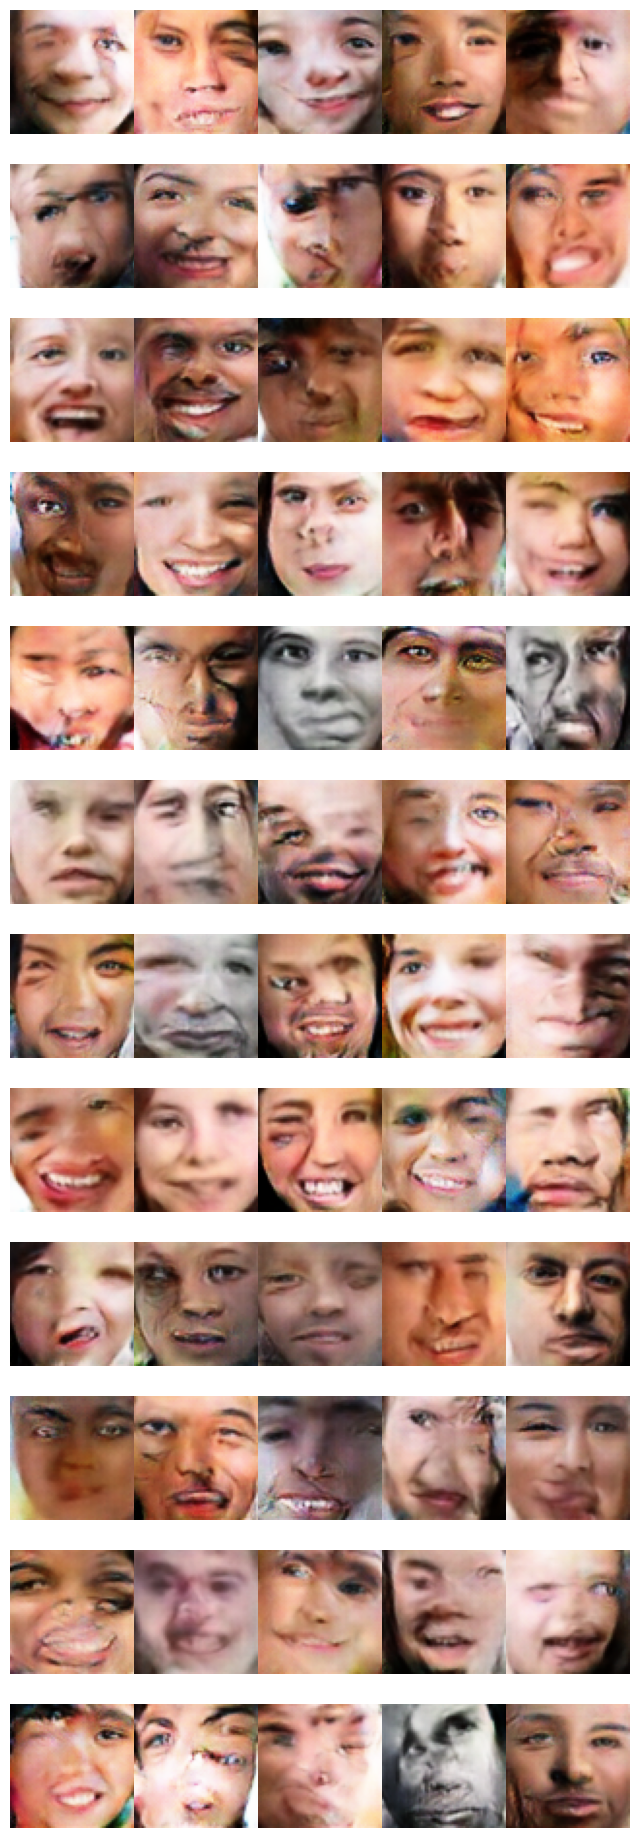

In [10]:
generate_images(generator, num_images=60,amount=5)

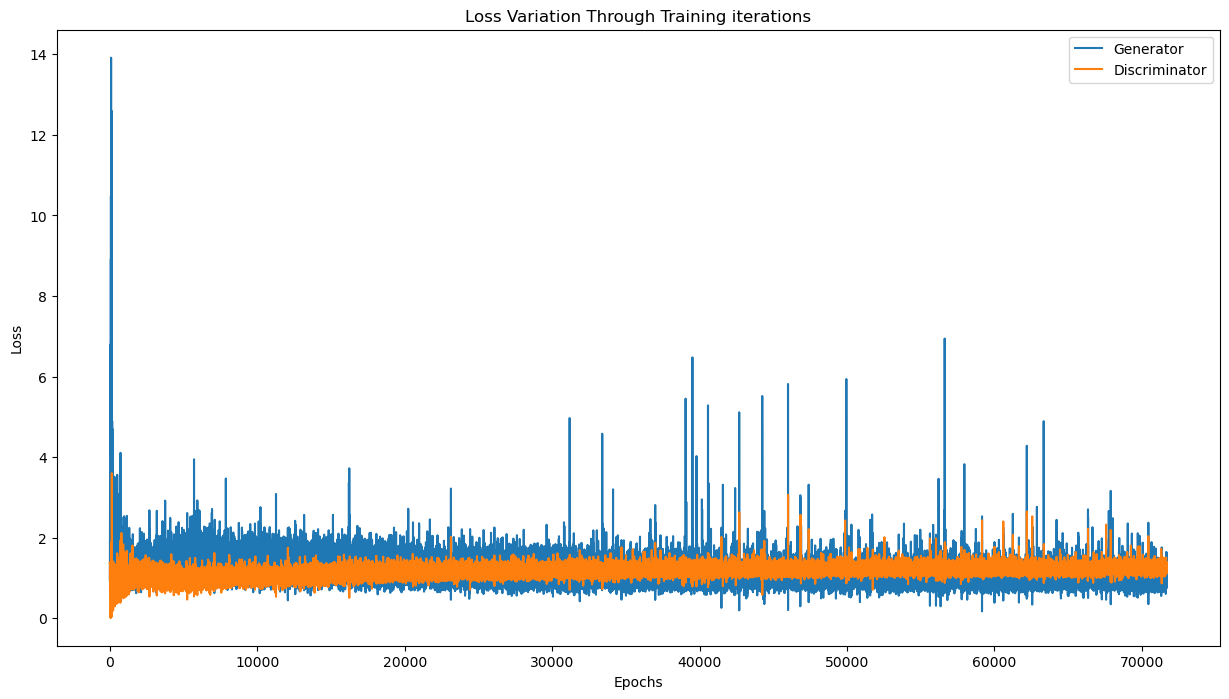

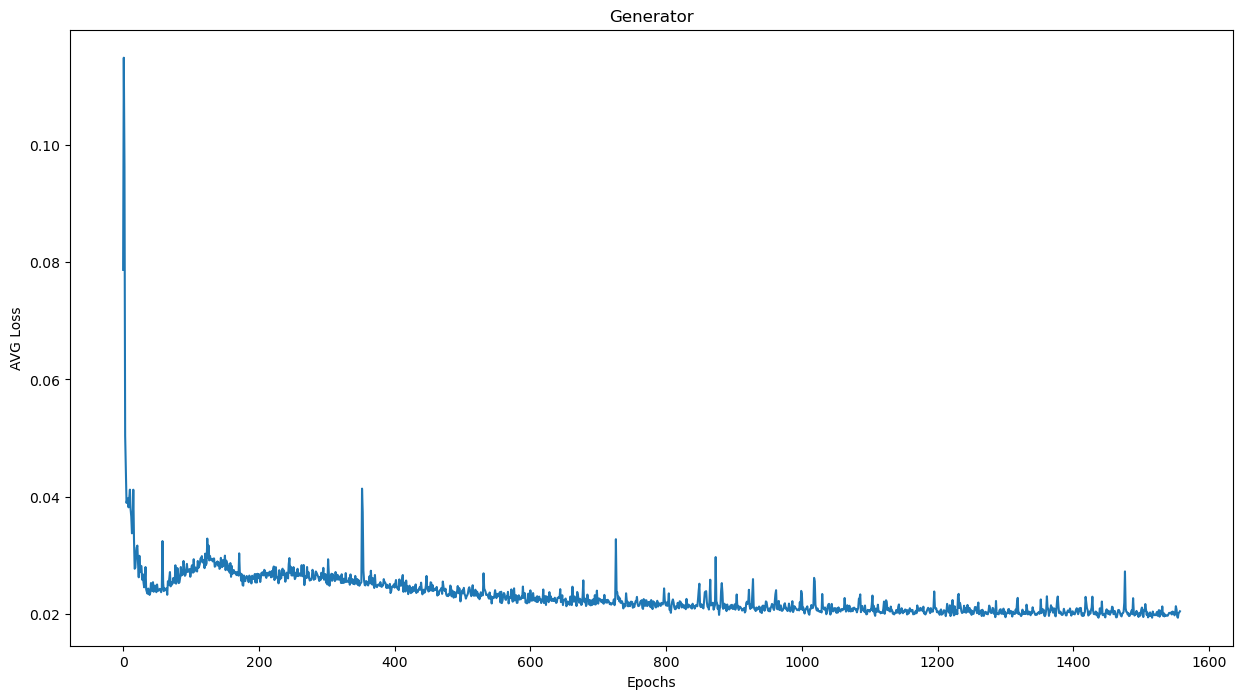

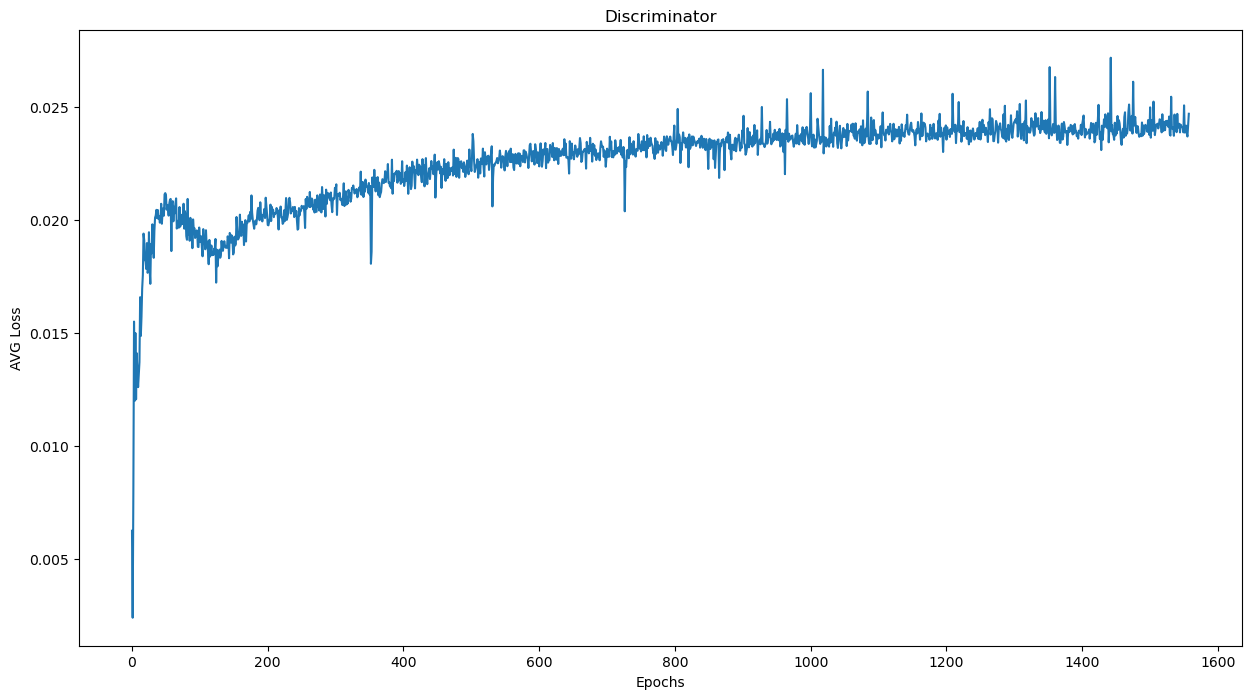

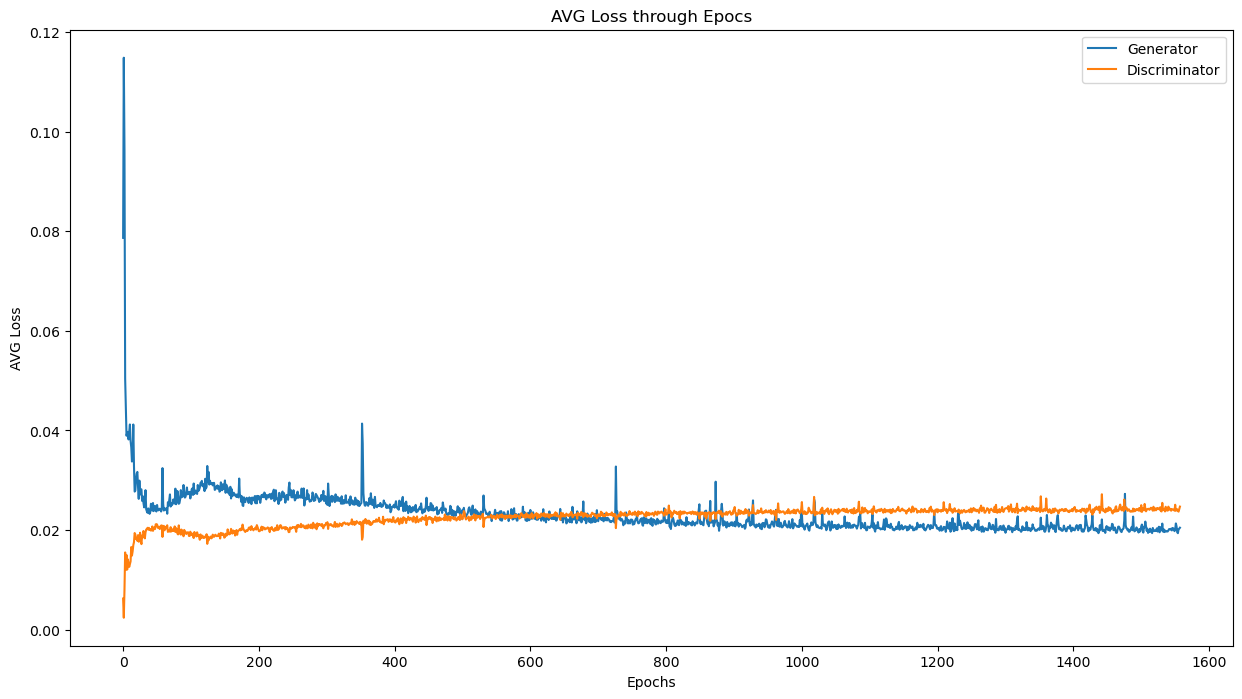

In [11]:
plt.figure(figsize=(15, 8))  
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation Through Training iterations')
plt.show()

plt.figure(figsize=(15, 8))  
plt.plot(G_AVGLoss_list)
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('Generator')
plt.show()

plt.figure(figsize=(15, 8))  
plt.plot(D_AVGLoss_list)
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('Discriminator')
plt.show()

plt.figure(figsize=(15, 8))  
plt.plot(G_AVGLoss_list, label='Generator')
plt.plot(D_AVGLoss_list, label='Discriminator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('AVG Loss through Epocs')
plt.show()        

## 09 - References

The original assigniment had more steps and was finished in group, I just took the parts in wich i worked on as base and improved

The original work credits:

#### 2023F-T3 AISC2007 - Deep Learning 01

### CASE STUDY Week 10 

Teacher : **Bhavik Gandhi**

Group 2

Abin Benny
Fabio Duarte Junior
Liniya Sheen
Manish Chhetri
Megha Ann Mathew
Megha Malhotra
Niraj Rokaya
Sandesh Pandey
Sukriti Chhibber

October 2023, Loyalist College in toronto, Term 3, AI and data science post-graduation course. North York GTA, Ontario, campus Victoria Park

I also used perplexity AI and Chat-GPT as co-pilot for the Alexnet implementation and fix errors during the coding.

